In [1]:
import numpy as np
import pandas as pd
import pickle
from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image as im
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add
import re
import json

In [2]:
def readfiles(path):
    with open(path) as f:
        caption=f.read()
    return caption

In [3]:
captions=readfiles("flikr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr8k.token.txt")
captions=captions.split('\n')[:-1]

In [4]:
first,second=captions[0].split('\t')
print(first.split('.')[0])

1000268201_693b08cb0e


In [5]:
#dictionary to map each caption with photo

In [6]:
descriptions={}
for x in captions:
    first,second=x.split('\t')
    img_name=first.split(".")[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
import cv2
import matplotlib.pyplot as plt

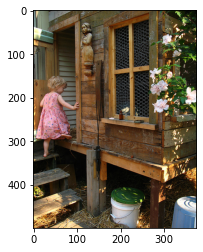

In [9]:
image_path="flikr8k/Flickr_Data/Flickr_Data/Images/"
image=cv2.imread(image_path+"1000268201_693b08cb0e.jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [10]:
#data cleaning
#no removing of stopwords as model need to know how to use 'a','the' to generate proper statement
#no stemming
#remove numbers and punctuations and conver tot lower case
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [11]:
#clean_text("helo hi 64 dhjf %%^^*^ fjnefj")

In [12]:
for key,caption in descriptions.items():
    for i in range(len(caption)):
        caption[i]=clean_text(caption[i])

In [13]:
f=open("flikr8k\descriptions_1.txt","w")
f.write(str(descriptions))
f.close()

In [14]:
#vocab

descriptions=None
with open("flikr8k/descriptions_1.txt","r") as f:#read as a file
    descriptions=f.read()
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)#convt to dict using json

In [15]:
#print(type(descriptions))

In [16]:
#vocab
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
print("vocab size:%d" %len(vocab))

vocab size:8424


In [17]:
total_words=[]
for key in descriptions.keys():
    for des in descriptions[key]:
        for i in des.split():
            total_words.append(i)


In [18]:
from collections import Counter
counter =Counter(total_words)
freq_count=dict(counter)
print(len(freq_count))

8424


In [19]:
#sort dict based on freq
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])
#filter
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]
print(len(total_words))

1845


In [20]:
sorted_freq_count

[('in', 18987),
 ('the', 18420),
 ('on', 10746),
 ('is', 9345),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176),
 ('wearing', 3062),
 ('at', 2916),
 ('people', 2887),
 ('water', 2790),
 ('red', 2691),
 ('young', 2630),
 ('brown', 2578),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2279),
 ('dogs', 2125),
 ('running', 2073),
 ('through', 2032),
 ('playing', 2008),
 ('while', 1968),
 ('shirt', 1962),
 ('down', 1843),
 ('standing', 1789),
 ('ball', 1783),
 ('little', 1768),
 ('grass', 1622),
 ('snow', 1547),
 ('child', 1545),
 ('person', 1542),
 ('jumping', 1473),
 ('over', 1415),
 ('three', 1389),
 ('front', 1386),
 ('sitting', 1368),
 ('holding', 1324),
 ('up', 1302),
 ('field', 1283),
 ('small', 1278),
 ('by', 1249),
 ('large', 1237),
 ('green', 1234),
 ('one', 1223),
 ('group', 1218),
 ('yellow', 1217),
 ('her', 1178),
 ('walk

In [21]:
#Prepare train and test data
train_data=readfiles("flikr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt")
test_data=readfiles("flikr8k\Flickr_Data\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt")


In [22]:
print(train_data)

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg
2851304910_b5721199bc.jpg
3423802527_94bd2b23b0.jpg
3356369156_074750c6cc.jpg
2294598473_40637b5c04.jpg
1191338263_a4fa073154.jpg
2380765956_6313d8cae3.jpg
3197891333_b1b0fd1702.jpg
3119887967_271a097464.jpg
2276499757_b44dc6f8ce.jpg
2506892928_7e79bec613.jpg
2187222896_c206d63396.jpg
2826769554_85c90864c9.jpg
3097196395_ec06075389.jpg
3603116579_4a28a932e2.jpg
3339263085_6db9fd0981.jpg
2532262109_87429a2cae.jpg
2076906555_c20dc082db.jpg
2502007071_82a8c639cf.jpg
3113769557_9edbb8275c.jpg
3325974730_3ee192e4ff.jpg
1655781989_b15ab4cbff.jpg
1662261486_db967930de.jpg
2410562803_56ec09f41c.jpg
2469498117_b4543e1460.jpg
69710415_5c2bfb1058.jpg
3414734842_beb543f400.jpg
3006217970_90b42e6b27.jpg
2192411521_9c7e488c5e.jpg
3535879138_9281d

In [23]:
train=[row.split(".")[0] for row in train_data.split('\n')[:-1]]
test=[row.split(".")[0] for row in train_data.split('\n')[:-1]]

In [24]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [25]:
#prepare description for the training data
#add start and end tokens for model to recognise where sentence will start and end
train_description={}
for image_id in train:
    train_description[image_id]=[]
    for cap in descriptions[image_id]:
        tokenized_caption="startseq " + cap + " endseq"
        train_description[image_id].append(tokenized_caption)

In [26]:
train_description['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [27]:
#converting images and text to features
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [28]:
#we will use this model o extract features
#we use globalaverage pooling layer for this
#model.input is input to resnet model adn model.layers is output
model_new=Model(model.input,model.layers[-2].output)#model.layer[-2] is global average pooling layer
#we input an image or m dimension and and get output of m x 2048 dimension these are the feature vectors


In [29]:
def preprocess_img(img):
    img=im.load_img(img,target_size=(224,224))
    img=im.img_to_array(img)
    img=np.expand_dims(img,axis=0)#original image size is(224,224,3) and when we feed it to a model it goes in a certain batch size (b,224,224,3) which is 4d tensor so to conver this image we use expand_dims(img,axis=0) so now image looks like (1,224,224,3), we can also use reshape
    #normalization
    img= preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


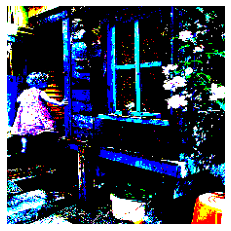

In [30]:
img=preprocess_img(image_path + "1000268201_693b08cb0e.jpg")
plt.imshow(img[0])#img[0] as it is a 4d tensor
plt.axis("off")
plt.show()

In [31]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector=feature_vector.reshape(2048,)
    return feature_vector

In [32]:
encode_image(image_path+"1000268201_693b08cb0e.jpg")

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [ ]:
start=time()
encoding_train={}
#image_id--> feature_vector extracted from resnet image
for ix,img_id in enumerate(train):
    img_path=image_path +"/"+img_id+".jpg"
    encoding_train[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("encoding in progress  time step %d"%ix)
end_t=time()
print("total time taken :",end_t-start)

In [ ]:
#Store everything to the disk
#pickle allows us to store object in ram in a file
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [ ]:
start=time()
encoding_test={}
#image_id--> feature_vector extracted from resnet image
for ix,img_id in enumerate(test):
    img_path=image_path +"/"+img_id+".jpg"
    encoding_test[img_id]=encode_image(img_path)
    
    if ix%100==0:
        print("encoding in progress  time step %d"%ix)
end_t=time()
print("total time taken :",end_t-start)

In [ ]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [33]:
#preprocess captions
word2index={}
index2word={}
for i,word in enumerate(total_words):
    word2index[word]=i+1 #we are not using dictionary index 0 as we use 0 for padding i.e making it all same size
    index2word[i+1]=word
    
    

In [34]:
word2index['dog']

6

In [51]:
#add start seq and end seq to the dict
index2word[1846]='startseq'
word2index['startseq']=1846

index2word[1847]='endseq'
word2index['endseq']=1847

In [52]:
len(word2index)

1847

In [53]:
vocab_size=len(word2index)
vocab_size=vocab_size+1

In [54]:
vocab_size

1848

In [55]:
max_len=0
for key in train_description.keys():
    for cap in train_description[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)       

35


In [56]:
with open("Image Captioning/word2index.pkl","wb") as w2i:
    pickle.dump(word2index,w2i)
   

In [57]:
with open("Image Captioning/index2word.pkl","wb") as i2w:
    pickle.dump(index2word,i2w)

In [ ]:
#word2index

In [ ]:
#train_description

In [ ]:
encoding_train

In [ ]:
#joint probability (prob of w1 given w0 appeared * prob of w2 given w0 and w1 appeared....)
#this is language modelling
#building a data generator
def data_generator(train_description,encoding_train,word2index,max_len,batch_size):
    X1,X2,y=[],[],[]
    n=0
    while True:
        for key,cap_list in train_description.items():
            n+=1
            photo=encoding_train[key]
            for cap in cap_list:
                seq=[word2index[word] for word in cap.split() if word in word2index]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    
                    
                    xi=pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi=to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                if n==batch_size:
                    yield([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y=[],[],[]
                    n=0
            
            
    

In [ ]:
#word embeddings
f=open('glove.6B.50d.txt',encoding='utf8')

In [ ]:
embedding_index={}
for line in f:
    values=line.split()
    print(values)
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
#glove file has word and 50 weights assigned to it with line.split() we makea n list and select the 0th index as word and convert the weights into array and inset it into the dictionary corresponding to the word

In [ ]:
embedding_index['apple']

In [ ]:
 f.close()

In [ ]:
def get_embedding_matrix():
    embedding_output={}
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word2index.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [ ]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

In [ ]:
#embedding_matrix[1847]

In [ ]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1)


In [ ]:
#caption input
input_captions=Input(shape=(max_len,))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [ ]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

#combined model
model=Model(inputs=[[input_img_features,input_captions]],outputs=outputs)
model.summary()

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
##train model
epochs=20
batch_size=3
steps=len(train_description)//200

In [ ]:
def train():
    for i in range(epochs):
        generator=data_generator(train_description,encoding_train,word2index,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')
    

In [ ]:
train()

In [ ]:
def predict_captions(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence=[word2index[w] for w in in_text.split() if w in word2index]
        sequence=pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax()
        word=index2word[ypred]
        in_text+=(' '+word)
        
        if word=='endseq':
            break
            
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption) 
    return final_caption
        
        

In [ ]:
encoding_test

In [ ]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("flikr8k/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_captions(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    

In [ ]:
all_img_names

In [ ]:
import tensorflow as tf

In [ ]:
print(tf. __version__)